In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [2]:
def comparator(B):
    b = bin(B)[2:]
    n = len(b) + 2
    b = bin(B)[2:].zfill(n)
    num_qubits = 2 * n + 1
    qr = QuantumRegister(num_qubits, 'qr')
    qc = QuantumCircuit(qr)

    qc.barrier()

    # Applying x gates
    idxOfa = len(b) - 1
    qc.x(qr[0])
    for i in range(3, num_qubits, 2):
        qc.x(qr[i])

    qc.barrier()

    idx = n - 1
    if (b[idx] == '1'):
        qc.x(qr[1])

    qc.ccx(qr[0], qr[1], qr[2])
    if (b[idx] == '1'):
        qc.x(qr[1])

    idx = idx - 1

    qc.barrier()

    ancilla_qubit_index = 2
    aIdx = 3

    for i in range(0, n - 1):
        if (b[idx] == '1'):
            qc.x(qr[1])

        qc.cx(qr[ancilla_qubit_index], qr[aIdx])
        qc.cx(qr[ancilla_qubit_index], qr[1])

        qc.ccx(qr[1], qr[aIdx], qr[ancilla_qubit_index + 2])

        qc.cx(qr[ancilla_qubit_index], qr[1])

        qc.cx(qr[ancilla_qubit_index], qr[ancilla_qubit_index + 2])

        if (b[idx] == '1'):
            qc.x(qr[1])
        
        qc.barrier()

        aIdx = aIdx + 2
        ancilla_qubit_index = ancilla_qubit_index + 2
        idx = idx - 1

    # qc.x(qr[num_qubits - 1])

    '''
    # Uncomputation
    aIdx = num_qubits - 2
    for i in range(0, n - 1):
        qc.cx(qr[aIdx - 1], qr[aIdx])
        aIdx = aIdx - 2

    qc.barrier()

    idxOfa = len(b) - 1
    qc.x(qr[0])
    for i in range(3, num_qubits, 2):
        qc.x(qr[i])

    '''
    
    return qc

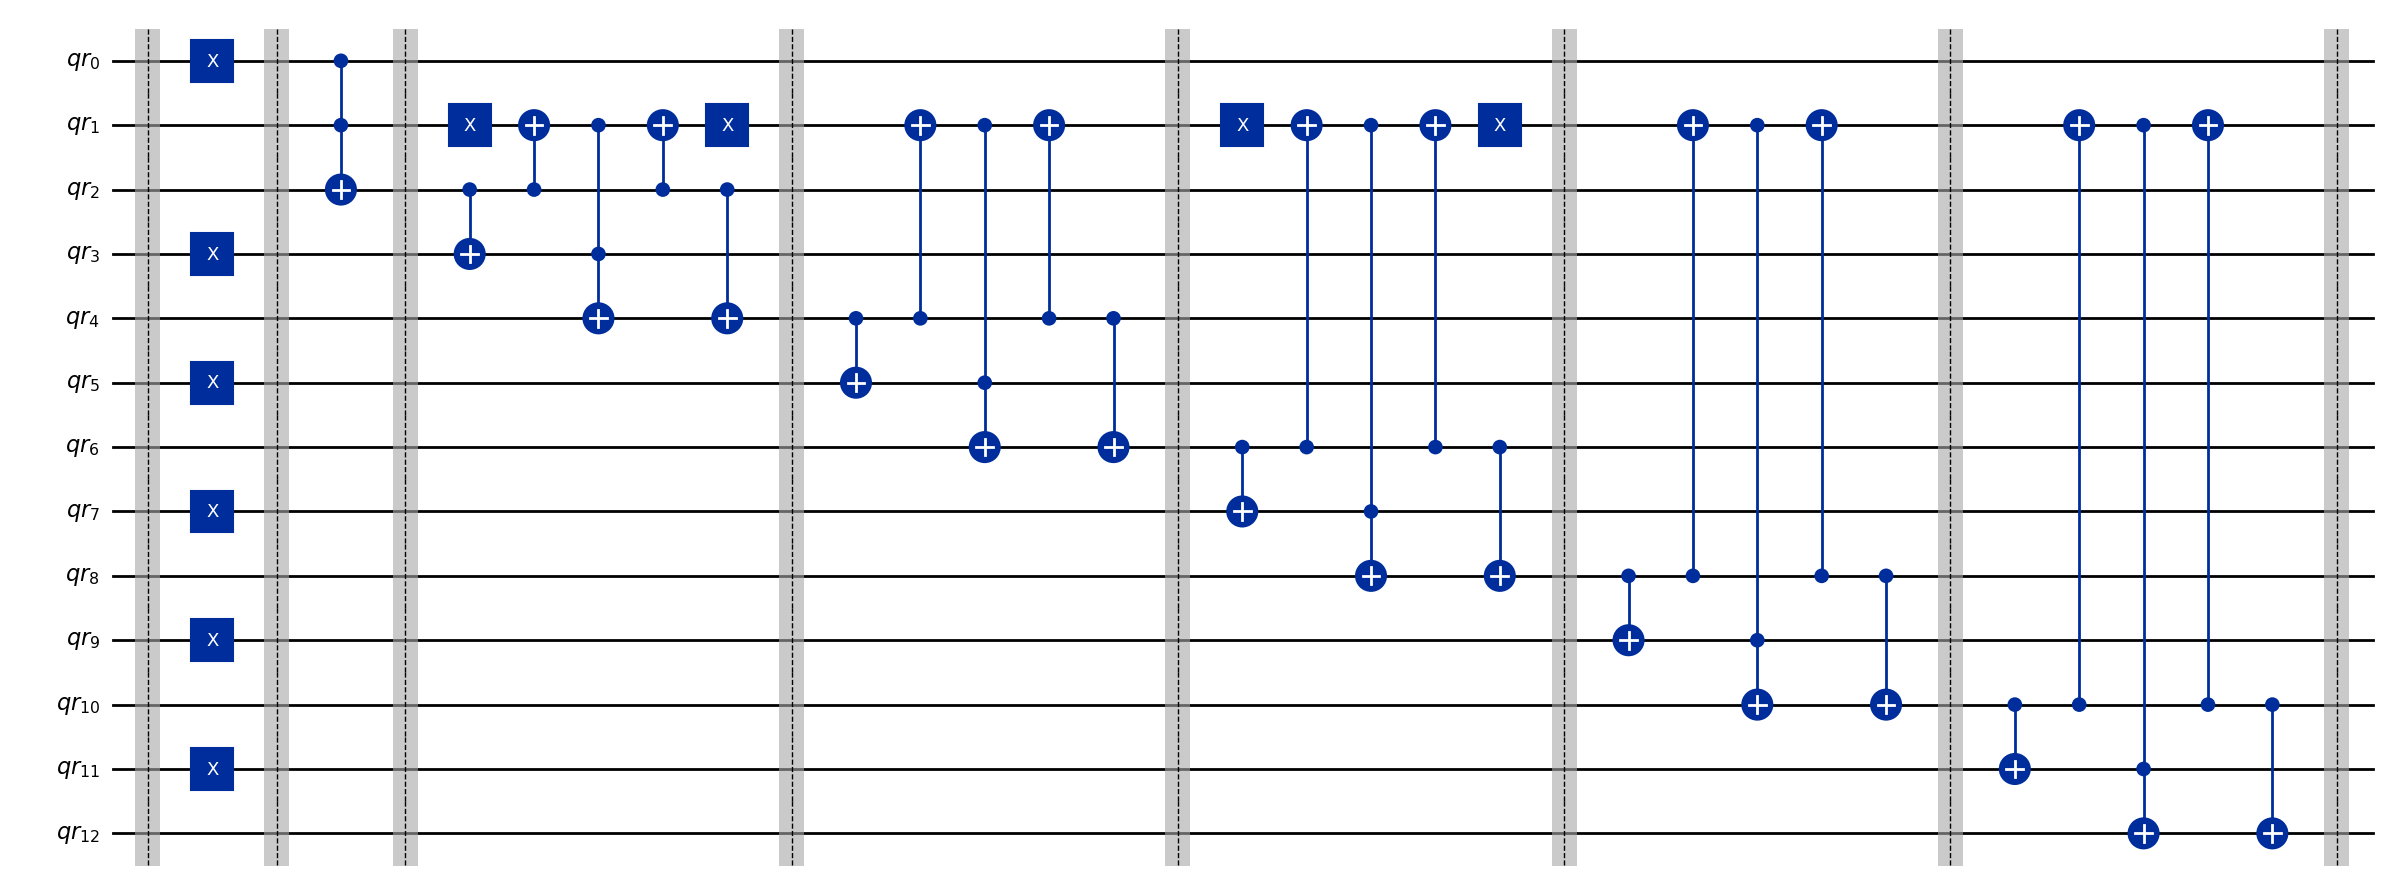

In [3]:
comparator(10).draw('mpl', fold = -1)

In [4]:
def reversed_comparator(B):
    b = bin(B)[2:]
    n = len(b) + 2
    b = bin(B)[2:].zfill(n)
    num_qubits = 2 * n + 1
    qr = QuantumRegister(num_qubits, 'qr')
    qc = QuantumCircuit(qr)

    qc.barrier()

    # Reverse logic gate applications
    ancilla_qubit_index = 2 + 2 * (n - 2)
    aIdx = 3 + 2 * (n - 2)
    idx = 0

    for i in range(n - 1):
        if b[idx] == '1':
            qc.x(qr[1])

        qc.cx(qr[ancilla_qubit_index], qr[ancilla_qubit_index + 2])
        qc.cx(qr[ancilla_qubit_index], qr[1])

        qc.ccx(qr[1], qr[aIdx], qr[ancilla_qubit_index + 2])

        qc.cx(qr[ancilla_qubit_index], qr[1])
        qc.cx(qr[ancilla_qubit_index], qr[aIdx])

        if b[idx] == '1':
            qc.x(qr[1])

        qc.barrier()

        aIdx -= 2
        ancilla_qubit_index -= 2
        idx += 1

    qc.barrier()

    # Undo initial Toffoli
    idx = n - 1
    if b[idx] == '1':
        qc.x(qr[1])

    qc.ccx(qr[0], qr[1], qr[2])

    if b[idx] == '1':
        qc.x(qr[1])

    qc.barrier()

    # Undo initial X gates
    qc.x(qr[0])
    for i in range(3, num_qubits, 2):
        qc.x(qr[i])

    qc.barrier()

    return qc

In [5]:
def comparator_gate(B):
    circuit = comparator(B)
    gate = circuit.to_instruction()
    gate.label = "Comparator"
    return gate

In [6]:
def circuitInstruction(B):
    b = bin(B)[2:]
    n = len(b) + 2
    b = bin(B)[2:].zfill(n)
    num_qubits = 2 * n + 2
    qr = QuantumRegister(num_qubits, 'qr')
    qc = QuantumCircuit(qr)

    # Comparators
    qc.append(comparator(B).to_instruction(), qr[:num_qubits - 1])

    qc.cx(qr[num_qubits - 2], qr[num_qubits - 1])

    qc.append(reversed_comparator(B).to_instruction(), qr[:num_qubits - 1])

    # Amplification
    qc.h(qr[0])
    for i in range(3, num_qubits - 2, 2):
        qc.h(qr[i])
    
    qc.x(qr[0])
    for i in range(3, num_qubits - 2, 2):
        qc.x(qr[i])
    
    qc.h(qr[num_qubits - 3])

    selected_qubits = [qr[i] for i in [0] + list(range(3, num_qubits - 4, 2))]
    qc.mcx(selected_qubits, qr[num_qubits - 3])

    qc.h(qr[num_qubits - 3])

    qc.barrier()
    
    qc.x(qr[0])
    for i in range(3, num_qubits - 2, 2):
        qc.x(qr[i])

    qc.barrier()

    qc.h(qr[0])
    for i in range(3, num_qubits, 2):
        qc.h(qr[i])
    
    return qc

In [7]:
circuitInstruction(10).to_instruction()

Instruction(name='circuit-163', num_qubits=14, num_clbits=0, params=[])

In [12]:
def QRNGCircuit(B):
    b = bin(B)[2:]
    n = len(b) + 2
    b = bin(B)[2:].zfill(n)
    num_qubits = 2 * n + 2
    qr = QuantumRegister(num_qubits, 'qr')
    cr = ClassicalRegister(n - 2, 'cr')
    qc = QuantumCircuit(qr, cr)

    # Initial State Preparation
    qc.h(qr[0])
    for i in range(3, num_qubits - 2, 2):
        qc.h(qr[i])
    
    qc.x(qr[num_qubits - 1])
    qc.h(qr[num_qubits - 1])

    count = int(np.ceil((np.pi/4) * np.sqrt((2 ** n)/B))) + 1

    for _ in range(count):
        qc.append(circuitInstruction(B).to_instruction(), qr[:num_qubits])

    # Measurements
    qc.measure(qr[0], cr[0])
    cIdx = 1
    aIdx = 3

    for _ in range(0, n - 3):
        qc.measure(qr[aIdx], cr[cIdx])
        aIdx = aIdx + 2
        cIdx = cIdx + 1

    return qc

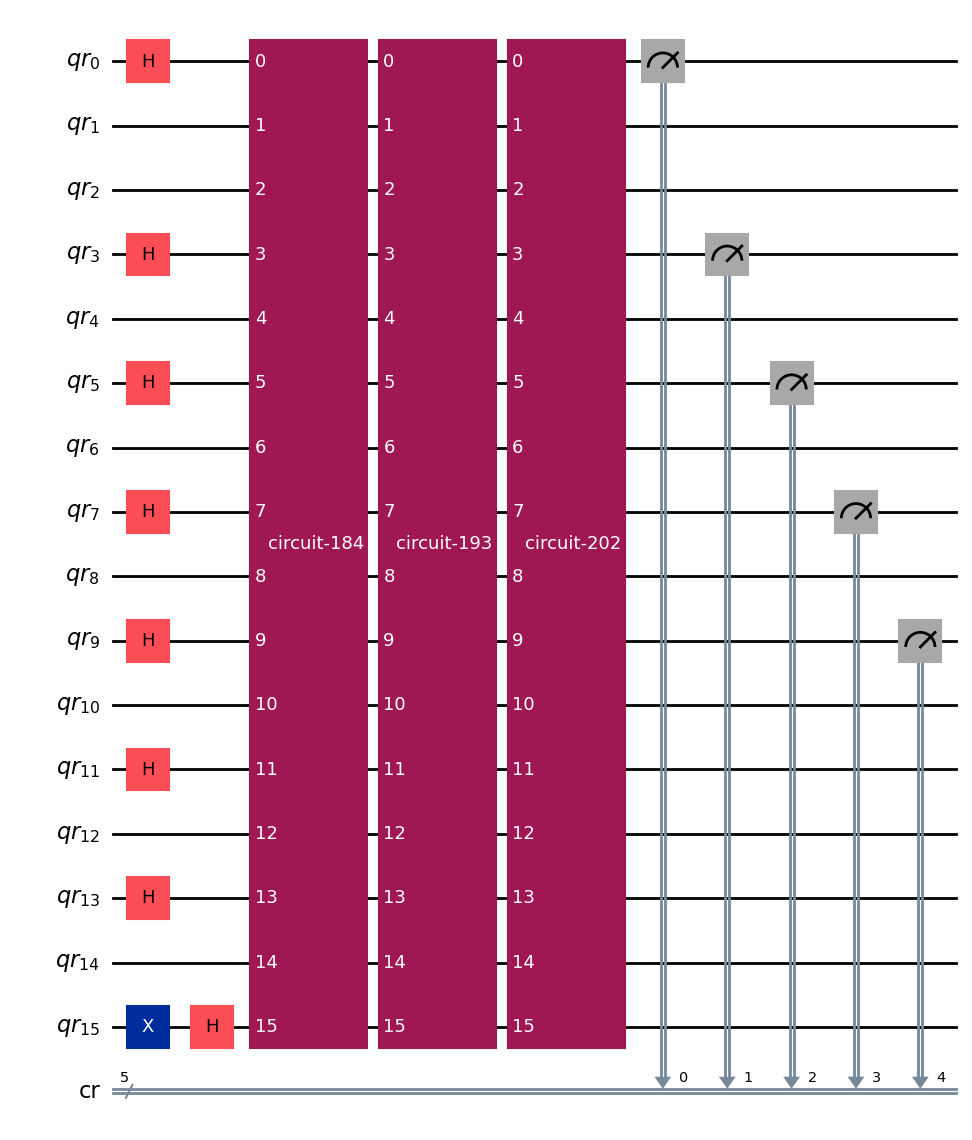

In [13]:
circ = QRNGCircuit(20)
circ.draw('mpl', fold = -1)

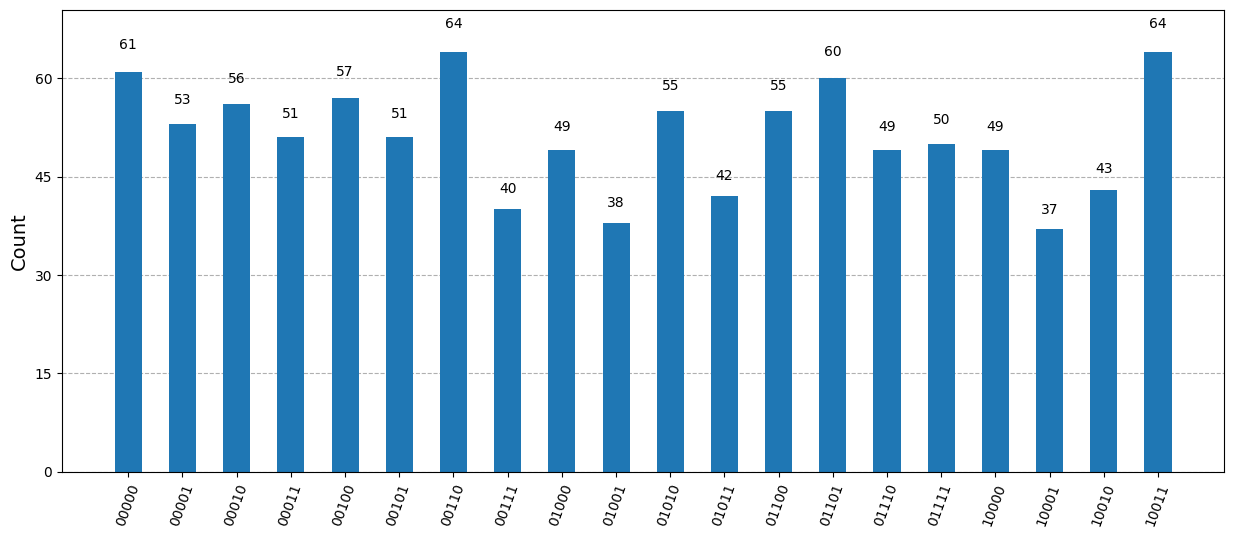

In [14]:
result = AerSimulator().run(transpile(circ, AerSimulator())).result()
statistics = result.get_counts()
plot_histogram(statistics, figsize=(15, 6))

In [15]:
def QRNG(B):
    simulator = AerSimulator()
    circuit = QRNGCircuit(B)
    transpiled_circuit = transpile(circuit, simulator)

    while True:
        result = simulator.run(transpiled_circuit, shots=1).result()
        statistics = result.get_counts()
        number = int(list(statistics.keys())[0], 2)

        if number < B:
            return number

In [21]:
QRNG(20)

0